In [317]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, brier_score_loss
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
import time

In [318]:

file_path = 'assessment-item1\dementia_data-MRI-features.csv'  # Replace with your local file path
dementia_df = pd.read_csv(file_path)


In [319]:
# Drop irrelevant columns
dementia_df = dementia_df.drop(columns=['Subject ID', 'MRI ID'], errors='ignore')


In [320]:
# Ensure Group is binary-encoded
dementia_df['Group'] = dementia_df['Group'].apply(lambda x: 1 if x == 'Demented' else 0)

In [321]:
# Impute missing values for all columns based on their data type
for column in dementia_df.columns:
    if dementia_df[column].dtype in ['float64', 'int64']:  # Numeric columns
        dementia_df[column].fillna(dementia_df[column].median(), inplace=True)
    else:  # Categorical columns
        dementia_df[column].fillna(dementia_df[column].mode()[0], inplace=True)

C:\Users\msi 1\AppData\Local\Temp\ipykernel_5700\3103822075.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dementia_df[column].fillna(dementia_df[column].median(), inplace=True)
C:\Users\msi 1\AppData\Local\Temp\ipykernel_5700\3103822075.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [322]:
# # Adjusting bins for discretization to capture more detail
# dementia_df['Age'] = pd.cut(dementia_df['Age'], bins=4, labels=['young', 'middle-aged', 'older', 'elderly'])
# dementia_df['MMSE'] = pd.cut(dementia_df['MMSE'], bins=4, labels=['very low', 'low', 'medium', 'high'])
# dementia_df['CDR'] = pd.cut(dementia_df['CDR'], bins=[-0.1, 0.25, 0.5, 1.0, 2.0], labels=['none', 'mild', 'moderate', 'severe'])
# dementia_df['eTIV'] = pd.cut(dementia_df['eTIV'], bins=4, labels=['very low', 'low', 'medium', 'high'])
# dementia_df['nWBV'] = pd.cut(dementia_df['nWBV'], bins=4, labels=['very low', 'low', 'medium', 'high'])
# dementia_df['ASF'] = pd.cut(dementia_df['ASF'], bins=4, labels=['very low', 'low', 'medium', 'high'])

In [323]:

# Adjusting bins for discretization to capture more detail
dementia_df['Age'] = pd.cut(dementia_df['Age'], bins=4, labels=False)
dementia_df['MMSE'] = pd.cut(dementia_df['MMSE'], bins=4, labels=False)
dementia_df['CDR'] = pd.cut(dementia_df['CDR'], bins=[-0.1, 0.25, 0.5, 1.0, 2.0], labels=False)
dementia_df['eTIV'] = pd.cut(dementia_df['eTIV'], bins=4, labels=False)
dementia_df['nWBV'] = pd.cut(dementia_df['nWBV'], bins=4, labels=False)
dementia_df['ASF'] = pd.cut(dementia_df['ASF'], bins=4, labels=False)

In [324]:
# def get_bin(value, bins):
#     bin_index = pd.cut([value], bins=bins, labels=False)[0]
#     if pd.isna(bin_index):  # Handle values outside the bin range
#         bin_index = 0 if value < bins[0] else len(bins) - 2  # Use nearest bin
#     return bin_index

In [325]:
# age_bins = pd.cut(dementia_df['Age'], bins=4, retbins=True)[1]
# mmse_bins = pd.cut(dementia_df['MMSE'], bins=4, retbins=True)[1]
# cdr_bins = pd.cut(dementia_df['CDR'], bins=[-0.1, 0.25, 0.5, 1.0, 2.0], retbins=True)[1]
# etiv_bins = pd.cut(dementia_df['eTIV'], bins=4, retbins=True)[1]
# nwbv_bins = pd.cut(dementia_df['nWBV'], bins=4, retbins=True)[1]
# asf_bins = pd.cut(dementia_df['ASF'], bins=4, retbins=True)[1]

In [326]:
# Define the Predefined Bayesian Network Structure
predefined_structure = BayesianNetwork([
    ('Age', 'MMSE'),
    ('Age', 'CDR'),
    ('MMSE', 'Group'),
    ('CDR', 'Group'),
    ('eTIV', 'nWBV'),
    ('nWBV', 'Group'),
    ('ASF', 'nWBV'),
    ('Visit', 'Group'),     # Adding Visit
    ('EDUC', 'MMSE'),       # Adding EDUC linked to MMSE (as a plausible relationship)
    ('SES', 'Group')        # Adding SES as potentially affecting Group
])









In [327]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(dementia_df, test_size=0.2, stratify=dementia_df['Group'], random_state=42)


In [328]:
# Fit the model with Maximum Likelihood Estimation (MLE) using the predefined structure
start_train_time = time.time()
predefined_structure.fit(train_df, estimator=MaximumLikelihoodEstimator)
train_time = time.time() - start_train_time

# Initialize inference on the predefined model
predefined_inference = VariableElimination(predefined_structure)

# Define binning for each continuous feature (using the same bins as in preprocessing)
age_bins = pd.cut(dementia_df['Age'], bins=4, retbins=True)[1]
mmse_bins = pd.cut(dementia_df['MMSE'], bins=4, retbins=True)[1]
cdr_bins = pd.cut(dementia_df['CDR'], bins=[-0.1, 0.25, 0.5, 1.0, 2.0], retbins=True)[1]
etiv_bins = pd.cut(dementia_df['eTIV'], bins=4, retbins=True)[1]
nwbv_bins = pd.cut(dementia_df['nWBV'], bins=4, retbins=True)[1]
asf_bins = pd.cut(dementia_df['ASF'], bins=4, retbins=True)[1]

# Helper function to map continuous values to bins
def get_bin(value, bins):
    bin_index = pd.cut([value], bins=bins, labels=False)[0]
    if pd.isna(bin_index):  # Handle values outside the bin range
        bin_index = 0 if value < bins[0] else len(bins) - 2  # Use nearest bin index
    return int(bin_index)

# Evaluate the model
y_true = test_df['Group'].values
y_pred = []
y_proba = []

In [329]:
# start_test_time = time.time()
# for index, row in test_df.iterrows():
#     # Prepare evidence by excluding 'Group' and any irrelevant columns like 'MR Delay'
#     evidence = {k: v for k, v in row.drop(['Group', 'MR Delay']).to_dict().items() if k in predefined_structure.nodes()}
    
#     # Get probability distribution for the 'Group' variable given the filtered evidence
#     query_result = predefined_inference.query(variables=['Group'], evidence=evidence)
#     prob = query_result.values[1]  # Probability of Group=1 (Demented)
#     y_proba.append(prob)
#     y_pred.append(1 if prob >= 0.5 else 0)  # Using 0.5 as a threshold for binary classification
# test_time = time.time() - start_test_time

In [330]:
# Start testing time
start_test_time = time.time()
for index, row in test_df.iterrows():
    # Convert continuous values to bins and prepare evidence
    evidence = {
        'Visit': row['Visit'],
        'Age': get_bin(row['Age'], age_bins),
        'EDUC': row['EDUC'],
        'SES': row['SES'],
        'MMSE': get_bin(row['MMSE'], mmse_bins),
        'CDR': get_bin(row['CDR'], cdr_bins),
        'eTIV': get_bin(row['eTIV'], etiv_bins),
        'nWBV': get_bin(row['nWBV'], nwbv_bins),
        'ASF': get_bin(row['ASF'], asf_bins)
    }

    # Debugging: Print evidence to verify values
    print(f"Evidence for row {index}: {evidence}")
    
    # Query probability distribution for 'Group' with the prepared evidence
    try:
        query_result = predefined_inference.query(variables=['Group'], evidence=evidence)
        prob = query_result.values[1]  # Probability of Group=1 (Demented)
        y_proba.append(prob)
        y_pred.append(1 if prob >= 0.5 else 0)  # Using 0.5 as a threshold for classification
    except KeyError as e:
        print(f"KeyError for row {index}: {e}")
test_time = time.time() - start_test_time

Evidence for row 154: {'Visit': 1, 'Age': 2, 'EDUC': 13, 'SES': 2.0, 'MMSE': 3, 'CDR': 3, 'eTIV': 1, 'nWBV': 1, 'ASF': 2}
Evidence for row 34: {'Visit': 3, 'Age': 2, 'EDUC': 14, 'SES': 1.0, 'MMSE': 3, 'CDR': 0, 'eTIV': 1, 'nWBV': 1, 'ASF': 2}
Evidence for row 193: {'Visit': 2, 'Age': 1, 'EDUC': 12, 'SES': 4.0, 'MMSE': 3, 'CDR': 0, 'eTIV': 1, 'nWBV': 1, 'ASF': 1}
Evidence for row 282: {'Visit': 2, 'Age': 1, 'EDUC': 16, 'SES': 2.0, 'MMSE': 3, 'CDR': 0, 'eTIV': 0, 'nWBV': 2, 'ASF': 3}
Evidence for row 102: {'Visit': 1, 'Age': 0, 'EDUC': 16, 'SES': 3.0, 'MMSE': 3, 'CDR': 0, 'eTIV': 1, 'nWBV': 3, 'ASF': 1}
Evidence for row 92: {'Visit': 2, 'Age': 1, 'EDUC': 18, 'SES': 1.0, 'MMSE': 3, 'CDR': 0, 'eTIV': 0, 'nWBV': 1, 'ASF': 2}
Evidence for row 236: {'Visit': 2, 'Age': 1, 'EDUC': 13, 'SES': 2.0, 'MMSE': 3, 'CDR': 2, 'eTIV': 1, 'nWBV': 1, 'ASF': 1}
Evidence for row 81: {'Visit': 1, 'Age': 1, 'EDUC': 16, 'SES': 1.0, 'MMSE': 3, 'CDR': 0, 'eTIV': 0, 'nWBV': 2, 'ASF': 2}
Evidence for row 35: {'Visi

In [331]:
# After splitting data
y_true = test_df['Group'].values
print("Unique values in y_true:", np.unique(y_true))

Unique values in y_true: [0 1]


In [332]:
# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_proba)
kl_divergence = log_loss(y_true, y_proba)  # Log Loss approximates KL Divergence in binary classification
brier_score = brier_score_loss(y_true, y_proba)

# Print Results
print("Model Evaluation Metrics for Predefined Bayesian Network:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc_score:.4f}")
print(f"Kullback-Leibler Divergence (Log Loss): {kl_divergence:.4f}")
print(f"Brier Score: {brier_score:.4f}")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Testing Time: {test_time:.4f} seconds")

Model Evaluation Metrics for Predefined Bayesian Network:
Accuracy: 0.8800
AUC: 0.9149
Kullback-Leibler Divergence (Log Loss): 0.7578
Brier Score: 0.1133
Training Time: 0.0865 seconds
Testing Time: 0.2126 seconds


In [333]:
# query_result = predefined_inference.query(variables=['Group'], evidence={
#     'Age': 2,        # Represents a specific age range as defined by binning
#     'MMSE': 3,       # Represents a higher MMSE score bin
#     'CDR': 1,        # Represents 'mild' CDR bin (for example, if this corresponds to bin 1)
#     'eTIV': 2,
#     'nWBV': 1,
#     'ASF': 3
# })

In [334]:
# Define binning for each continuous feature (using the same bins as in preprocessing)
age_bins = pd.cut(dementia_df['Age'], bins=4, retbins=True)[1]
mmse_bins = pd.cut(dementia_df['MMSE'], bins=4, retbins=True)[1]
cdr_bins = pd.cut(dementia_df['CDR'], bins=[-0.1, 0.25, 0.5, 1.0, 2.0], retbins=True)[1]
etiv_bins = pd.cut(dementia_df['eTIV'], bins=4, retbins=True)[1]
nwbv_bins = pd.cut(dementia_df['nWBV'], bins=4, retbins=True)[1]
asf_bins = pd.cut(dementia_df['ASF'], bins=4, retbins=True)[1]

# Function to convert a continuous value to its bin index
def get_bin(value, bins):
    bin_index = pd.cut([value], bins=bins, labels=False)[0]
    if pd.isna(bin_index):  # Handle values outside the bin range
        bin_index = 0 if value < bins[0] else len(bins) - 2  # Use nearest bin index
    return int(bin_index)

# Prepare evidence with discretized values
query_evidence = {
    'Visit': 3,
    'Age': get_bin(80, age_bins),
    'EDUC': 12,
    #'SES': 2,
    'MMSE': get_bin(22, mmse_bins),
    'CDR': get_bin(0.5, cdr_bins),
    'eTIV': get_bin(1698, etiv_bins),
    'nWBV': get_bin(0.701, nwbv_bins),
    'ASF': get_bin(1.034, asf_bins)
}

# Run the query on the predefined Bayesian Network
query_result = predefined_inference.query(variables=['Group'], evidence=query_evidence)

# Print the query result
print("Query Result for P(Group=nondemented | evidence):\n", query_result)





# # Function to find bin index for a given value and bins
# def get_bin(value, bins):
#     return pd.cut([value], bins=bins, labels=False)[0]

# # Convert query values to bin indices
# query_evidence = {
#     'Visit': 2,
#     'Age': get_bin(88, age_bins),
#     'EDUC': 14,
#     'SES': 2,
#     'MMSE': get_bin(30, mmse_bins),
#     'CDR': get_bin(0, cdr_bins),
#     'eTIV': get_bin(2004, etiv_bins),
#     'nWBV': get_bin(0.681, nwbv_bins),
#     'ASF': get_bin(0.876, asf_bins)
# }

# # Now run the query with the converted evidence
# query_result = predefined_inference.query(variables=['Group'], evidence=query_evidence)
# print("Query Result:\n", query_result)

Query Result for P(Group=nondemented | evidence):
 +----------+--------------+
| Group    |   phi(Group) |
+==========+==============+
| Group(0) |       0.6174 |
+----------+--------------+
| Group(1) |       0.3826 |
+----------+--------------+


In [335]:
# Extract the probability of Group = 0 (nondemented) and Group = 1 (demented)
prob_nondemented = query_result.values[0]  # Probability of Group = 0
prob_demented = query_result.values[1]     # Probability of Group = 1

# Print out the specific probabilities
print(f"P(Group=nondemented | evidence): {prob_nondemented:.4f}")
print(f"P(Group=demented | evidence): {prob_demented:.4f}")



P(Group=nondemented | evidence): 0.6174
P(Group=demented | evidence): 0.3826


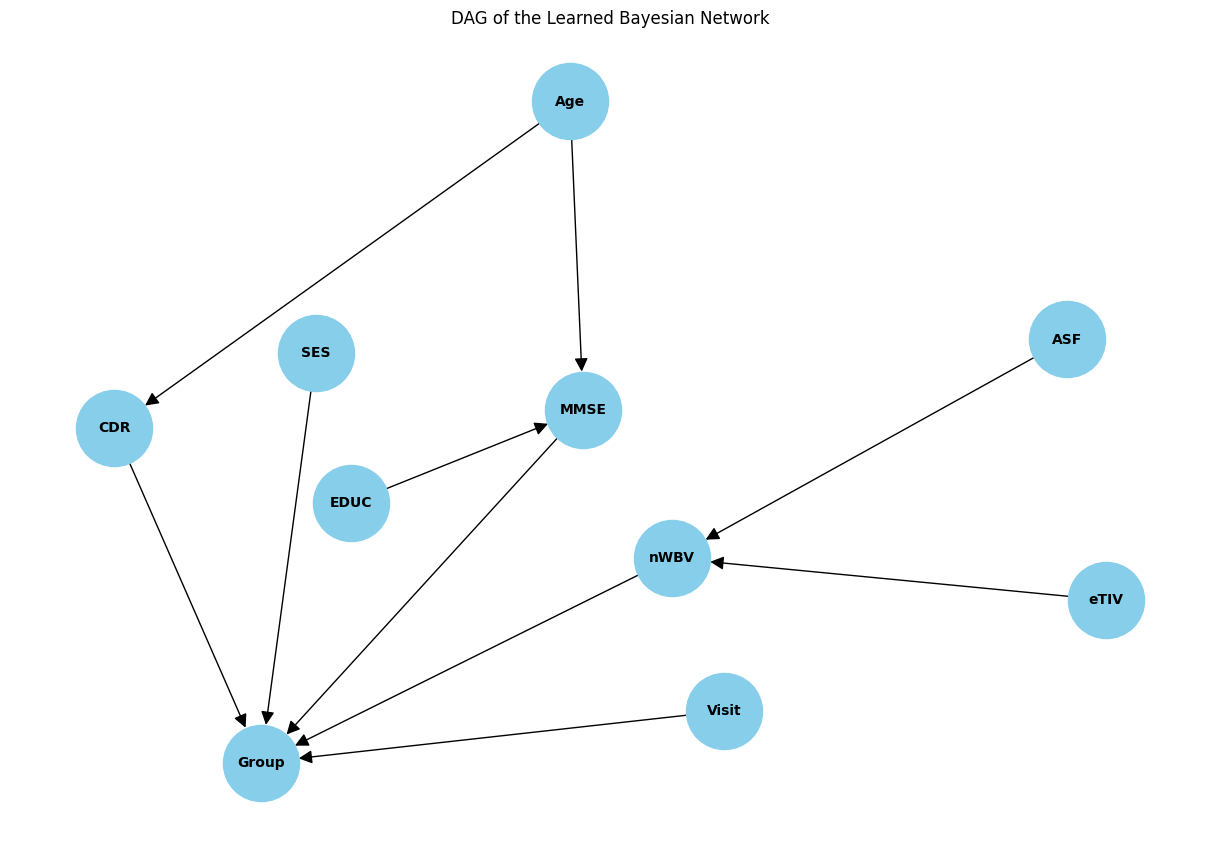

In [336]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork

# Plotting the learned Bayesian Network structure (DAG)
plt.figure(figsize=(12, 8))
G = nx.DiGraph()

# Add edges from the learned structure
G.add_edges_from(predefined_structure.edges())

# Draw the graph
pos = nx.spring_layout(G)  # You can use other layouts as well (e.g., circular, shell)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("DAG of the Learned Bayesian Network")
plt.show()
